# STUDENT MODELS WITH 10M PARAMETERS

## Imports

In [0]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import cifar10,cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import Sequence
from keras import regularizers
from keras.models import load_model
import os
from keras.models import Model
import h5py

import time

import colorsys #enables us to convert a rgb vector to a hsv vector
from skimage.color import rgb2hsv, hsv2rgb
from skimage.io import imread
from skimage.transform import resize

import cv2
import sys


# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Using TensorFlow backend.


### Import Dataset CIFAR_100


In [0]:
### LOAD CIFAR_100

reset_graph()
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print('x_train shape:', x_train.shape)

#Define num_classes
num_classes = 100


x_train shape: (50000, 32, 32, 3)


In [0]:
def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    
    Rows are scores for each class. 
    Columns are predictions (samples).
    """
    scoreMatExp = np.exp(np.asarray(x))
    return scoreMatExp / scoreMatExp.sum(0)

## 1- Creation of the dataset using distillation

In [0]:
#Load the teacher model

#teacher_model = load_model('keras_cifar10_trained_model2.h5')
teacher_model = load_model('cifar_100_teacher.h5')

#Get the layer just before the softmax layer
without_softmax_model = Model(inputs=teacher_model.input, outputs=teacher_model.get_layer('dense_3').output)

#Keep a copy of the original dataset before modifications
x_train_bis = np.copy(x_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Definitions of the different functions used in this ipynb

In [0]:
# random crop needed for training augmentation
def random_crop(img):
    height, width, _ = img.shape
    dy, dx = input_size, input_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    img = img[y:(y+dy), x:(x+dx), :]
    return img

# center crop needed for testing (validation & test sets)
def center_crop(img):
    height, width, _ = img.shape
    dy, dx = input_size, input_size
    x = int((width - dx + 1)/2)
    y = int((height - dy + 1)/2)
    img = img[y:(y+dy), x:(x+dx), :]
    return img
  
 # softmax function

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    
    Rows are scores for each class. 
    Columns are predictions (samples).
    """
    scoreMatExp = np.exp(np.asarray(x))
    return scoreMatExp / scoreMatExp.sum(0)

### Preparation of the data for Keras

In [0]:
#Divide into training and validation set

x_validation = x_train_bis[40000:]
x_train_bis = x_train_bis[:40000]


#Define input size for the data augmentation : we will keep input_size pixels after data augmentation
input_size = 28

### Cropping the images
X_train = np.zeros((np.shape(x_train_bis)[0],input_size,input_size,3))

#random crop for training set
for i in range(np.shape(x_train_bis)[0]):
  X_train[i] = random_crop(x_train_bis[i])
  
X_validation = np.zeros((np.shape(x_validation)[0],input_size,input_size,3))

#center crop for validation set, no need for data augmentation, just input_size size images
for i in range(np.shape(x_validation)[0]):
  X_validation[i] = center_crop(x_validation[i])
  
### Normalizing the data

X_train = X_train.astype('float32')
x_test = x_test.astype('float32')
X_validation = X_validation.astype('float32')
X_train /= 255
x_test /= 255
X_validation /= 255

y_train_soft = without_softmax_model.predict(X_train, batch_size=32, verbose=0, steps=None)
y_validation_soft = without_softmax_model.predict(X_validation, batch_size=32, verbose=0, steps=None)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

for i in range(len(y_train_soft)):
  y_train_soft[i] = y_train_soft[i]/np.linalg.norm(y_train_soft[i])

for i in range(len(y_validation_soft)):
  y_validation_soft[i] = y_validation_soft[i]/np.linalg.norm(y_validation_soft[i])

## 2- Creation of the student models with Keras

### A- MLP

#### One hidden layer

In [0]:
model = Sequential()

model.add(Dense(4000, input_shape=(28*28*3,)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(rate=0.3))

model.add(Dense(num_classes))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4000)              9412000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4000)              16000     
_________________________________________________________________
activation_1 (Activation)    (None, 4000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               400100    
Total params: 9,828,100
Trainable params: 9,820,100
Non-trainable params: 8,000
_________________________________________________________________


#### Two hidden layer

In [0]:
model = Sequential()

model.add(Dense(3000, input_shape=(28*28*3,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))


model.add(Dense(num_classes))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3000)              7059000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 3000)              12000     
_________________________________________________________________
activation_1 (Activation)    (None, 3000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
activation_2 (Activation)    (None, 1000)              0         
__________

#### Three hidden layer

In [0]:
model = Sequential()

model.add(Dense(2000, input_shape=(28*28*3,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(1500))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(2000))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.add(Dropout(rate=0.3))

model.add(Dense(num_classes))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2000)              4706000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2000)              8000      
_________________________________________________________________
activation_1 (Activation)    (None, 2000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              3001500   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1500)              6000      
_________________________________________________________________
activation_2 (Activation)    (None, 1500)              0         
__________

#### Four hidden layer

In [0]:
model = Sequential()

model.add(Dense(2000, input_shape=(28*28*3,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(1500))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.add(Dropout(rate=0.3))

model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(num_classes))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2000)              4706000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2000)              8000      
_________________________________________________________________
activation_1 (Activation)    (None, 2000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              3001500   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1500)              6000      
_________________________________________________________________
activation_2 (Activation)    (None, 1500)              0         
__________

### B- CNN

#### One convolutional layer

In [0]:
model = Sequential()
model.add(Conv2D(100, (3, 3), padding='same',
                 input_shape=(28,28,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(500))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 100)       2800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 100)       400       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 100)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               9800500   
__________

#### Two convolutional layer

In [0]:
model = Sequential()
model.add(Conv2D(300, (3, 3), padding='same',
                 input_shape=(28,28,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(120, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1600))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 300)       8400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 300)       1200      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 300)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 300)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 300)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 120)       324120    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 120)       480       
__________

#### Three convolutional layer

In [0]:
model = Sequential()
model.add(Conv2D(350, (3, 3), padding='same',
                 input_shape=(28,28,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(350, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(350, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(2500))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 350)       9800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 350)       1400      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 350)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 350)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 350)       1102850   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 350)       1400      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 350)       0         
__________

#### Four convolutional layer

In [0]:
model = Sequential()
model.add(Conv2D(325, (3, 3), padding='same',
                 input_shape=(28,28,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(325, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(375, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(375, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(2000))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 325)       9100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 325)       1300      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 325)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 325)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 325)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 325)       950950    
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 325)       1300      
__________

#### Test CNN : not used

In [0]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(28,28,3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(350))
model.add(Dense(num_classes))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
__________

## 3- Training the chosen student model

In [0]:
batch_size = 32
epochs = 30
data_augmentation = True #write False for a MLP and True for a CNN

#opt = keras.optimizers.rmsprop(lr=0.1, decay=1e-6)
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Let's train the model using RMSprop
model.compile(loss='mean_squared_error',
              optimizer=opt)


if data_augmentation == True:

  train_datagen = ImageDataGenerator(
          horizontal_flip=True  # randomly flip images
  )

  validation_and_test_datagen = ImageDataGenerator()


      # Batch generators
  train_generator = train_datagen.flow(
      X_train, 
      y_train_soft,
      batch_size=batch_size
  )

  validation_generator = validation_and_test_datagen.flow(
      X_validation, 
      y_validation_soft, 
      batch_size=batch_size
  )


      # this class is needed to adapt keras pipeline to shape modifications
  class crop_gen(Sequence):

      def __init__(self, gen):
          self.gen = gen
          self.x, self.y = next(gen)
          self.batch_size = batch_size

      def __len__(self):
          return self.gen.__len__()

      def __getitem__(self, idx):
          batch_x, batch_y = next(self.gen)
          batch_crops = np.zeros((batch_x.shape[0], input_size, input_size, 3))
          for i in range(batch_x.shape[0]):
              batch_crops[i] = random_crop(batch_x[i])
          return batch_crops, batch_y

  # this class is needed to adapt keras pipeline to shape modifications    
  class crop_gen_center(Sequence):

      def __init__(self, gen):
          self.gen = gen
          self.x, self.y = gen.__getitem__(0)
          self.batch_size = batch_size
          #self.classes = gen.classes
          self.class_indices = np.arange(num_classes) #gen.class_indices

      def __len__(self):
          return self.gen.__len__()


      def __getitem__(self, idx):
          batch_x, batch_y = next(self.gen)
          batch_crops = np.zeros((batch_x.shape[0], input_size, input_size, 3))
          for i in range(batch_x.shape[0]):
              batch_crops[i] = center_crop(batch_x[i])
          return batch_crops, batch_y

  #train_generator = crop_gen(train_generator)
  #validation_generator = crop_gen_center(validation_generator)

  # Fit the model on the batches generated by datagen.flow().
  print('x_train shape:', X_train.shape)
  print('x_validation shape:', X_validation.shape)
  history = model.fit_generator(
    train_generator,
    epochs=epochs,
    shuffle=True,
    validation_data=validation_generator,
    validation_steps = len(X_validation)/batch_size,
    steps_per_epoch = len(X_train)/batch_size,
    workers=4
  )
else:
  for i in range(len(X_train)):
    if np.random.uniform(0,1) > 0.5:
      X_train[i] = np.flip(X_train[i],axis=1)
      
  X_train = X_train.reshape(40000,28*28*3)
  X_validation = X_validation.reshape(10000,28*28*3)

  history = model.fit(X_train, y_train_soft,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_validation, y_validation_soft))
    
# Save model and weights
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
#model_path = os.path.join(save_dir, model_name)
#model.save(model_path)
#print('Saved trained model at %s ' % model_path)


X_test = np.zeros((np.shape(x_test)[0],input_size,input_size,3))

for i in range(np.shape(x_test)[0]):
  X_test[i] = center_crop(x_test[i])
  
if data_augmentation==False:
  X_test = X_test.reshape(10000,28*28*3)
  
  # Score trained model.
scores = model.evaluate(X_test, y_test_cat, verbose=1)
print('Test loss:', scores)
predictions = model.predict(X_test)

acc = 0
softmax_predictions = np.zeros((num_classes,10000))
for i in range(np.shape(X_test)[0]):
  softmax_predictions[:,i] = softmax(predictions[i,:])
  if np.argmax(softmax_predictions[:,i])==y_test[i]:
    acc = acc + 1
acc = acc/10000

print('Test accuracy:', acc)

x_train shape: (40000, 28, 28, 3)
x_validation shape: (10000, 28, 28, 3)
Epoch 1/30
1250/1250 [==============================] - 36s 29ms/step - loss: 0.0618 - val_loss: 0.0012
Epoch 2/30
1250/1250 [==============================] - 34s 27ms/step - loss: 0.0024 - val_loss: 6.4366e-04
Epoch 3/30
1250/1250 [==============================] - 33s 27ms/step - loss: 0.0010 - val_loss: 5.7260e-04
Epoch 4/30
1250/1250 [==============================] - 34s 27ms/step - loss: 7.5885e-04 - val_loss: 6.1131e-04
Epoch 5/30
1250/1250 [==============================] - 34s 27ms/step - loss: 6.0924e-04 - val_loss: 4.9698e-04
Epoch 6/30
1250/1250 [==============================] - 33s 27ms/step - loss: 5.1966e-04 - val_loss: 4.5689e-04
Epoch 7/30
1250/1250 [==============================] - 34s 27ms/step - loss: 4.5862e-04 - val_loss: 4.2215e-04
Epoch 8/30
1250/1250 [==============================] - 33s 27ms/step - loss: 4.2739e-04 - val_loss: 3.9120e-04
Epoch 9/30
1250/1250 [=========================

#### Plot the loss curve

dict_keys(['val_loss', 'loss'])


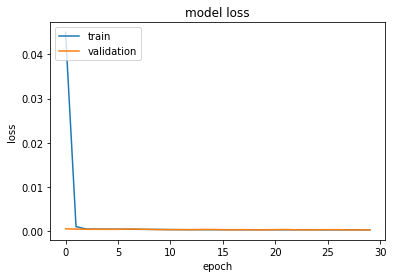

In [0]:
# list all data in historys
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Plot the different models

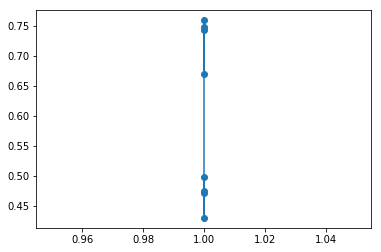

In [0]:
plt.plot([1,1,1,1,1,1,1,1,],[0.67,0.7481,0.7432,0.7596,0.4302,0.4751,0.4992,0.4725],marker='o')